Data load and unzip

In [71]:
import zipfile
import os

def unzip_file(zip_path, extract_to):
    os.makedirs(extract_to, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    print(f"Unzipped {zip_path} to {extract_to}")


zip_file_path = '/content/drive/MyDrive/Student/Mohit/Dataset/Fitzptrick_17k/Fitzptrick_17k.zip'
extract_directory = '/content/fitzpatrick17k'
unzip_file(zip_file_path, extract_directory)

Unzipped /content/drive/MyDrive/Student/Mohit/Dataset/Fitzptrick_17k/Fitzptrick_17k.zip to /content/fitzpatrick17k


In [72]:
import pandas as pd

df_cleaned = pd.read_csv('/content/drive/MyDrive/Student/Mohit/Dataset/Fitzptrick_17k/fitzpatrick17k.csv')


# Remove rows with -1 in 'fitzpatrick_scale' those are unknown sample
# df_cleaned = df_cleaned[df_cleaned['fitzpatrick_scale'] != -1]
df_cleaned.head()

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,url,url_alphanum
0,5e82a45bc5d78bd24ae9202d194423f8,3,3,drug induced pigmentary changes,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicmminoc...
1,fa2911a9b13b6f8af79cb700937cc14f,1,1,photodermatoses,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicpphoto...
2,d2bac3c9e4499032ca8e9b07c7d3bc40,2,3,dermatofibroma,benign dermal,benign,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicdderma...
3,0a94359e7eaacd7178e06b2823777789,1,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...
4,a39ec3b1f22c08a421fa20535e037bba,1,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...


In [73]:
df_img = pd.read_csv('/content/drive/MyDrive/Student/Mohit/Dataset/Fitzptrick_17k/V2/image_metadata_trainAug_testNonAuh_V3_with_fitzpatrick_scale.csv')
df_img.head()

,resized_image_path,three_partition_label,set,md5hash,fitzpatrick_scale
0,resized_image_path,three_partition_label,set,resized_image_path,NaN
1,/content/all_images/96e320998184af49bfc791c8f1...,malignant,train,96e320998184af49bfc791c8f1b0e174,3.0
2,/content/all_images/3b76144cda29793ac4bb709ab4...,non-neoplastic,train,3b76144cda29793ac4bb709ab4093531,2.0
3,/content/all_images/da81b0441ab66a8c3f55489a0d...,malignant,train,da81b0441ab66a8c3f55489a0d8a9572,1.0
4,/content/all_images/72430e826363a44a2f9d5dd7e8...,malignant,train,72430e826363a44a2f9d5dd7e88aed64,4.0


In [74]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ReduceLROnPlateau
import numpy as np

# Load the EfficientNetB0 model with ImageNet weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(1024, activation='relu')(x)  # Dense layer with 1024 units
x = BatchNormalization()(x)  # Batch normalization for stability
x = Dropout(0.5)(x)  # Dropout layer to prevent overfitting
predictions = Dense(3, activation='softmax')(x)  # Output layer for 3 classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# # Freeze the base model layers to train only the custom layers
for layer in base_model.layers:
    layer.trainable = False

csv_logger = CSVLogger('training_log.csv', append=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

# # Compile the model with custom class weights
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.load_weights('/content/drive/MyDrive/Student/Mohit/Model/Fitzpatrick_17k/V2/Final_bestRecall/EfficientNetB0_L2_MoreThreasehold_18_Sept_2024_V3.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Predicted class: 2
Confidence: 0.9511542


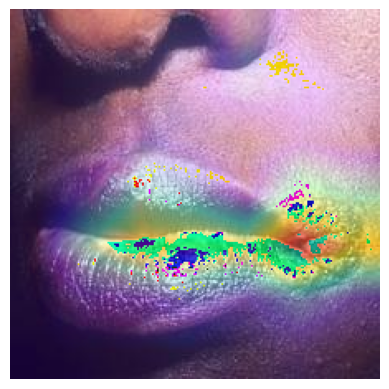

In [90]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Define your image path
# img_path = '/content/benign(t1).jpg'  # Replace with your actual image path
img_path = '/content/all_images/e6cc8d0173c203020f75acace996ee60.jpg'

# Define a preprocessing function based on the ImageDataGenerator you used
def preprocess_image(img):
    img = image.img_to_array(img)  # Convert image to array
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = tf.keras.applications.vgg19.preprocess_input(img)  # Preprocess for VGG19
    return img

# Load and preprocess the single image
img = image.load_img(img_path, target_size=(224, 224))  # Adjust size as per your model's input size
processed_img = preprocess_image(img)

# Make prediction
predictions = model.predict(processed_img)
predicted_class = np.argmax(predictions[0])
confidence = np.max(predictions[0])

# Print predicted class and confidence
print("Predicted class:", predicted_class)
print("Confidence:", confidence)

# Function to compute the Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[0][pred_index]  # Change here

    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Compute the pooled gradients (global average pooling)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply the pooled gradients with the conv layer output
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Generate Grad-CAM heatmap
last_conv_layer_name = 'block7a_project_conv'  # Change to the correct layer name based on your model architecture
heatmap = make_gradcam_heatmap(processed_img, model, last_conv_layer_name, pred_index=predicted_class)

# Function to superimpose the heatmap on the image
def superimpose_heatmap(heatmap, img_path, alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * alpha + img
    return np.uint8(superimposed_img)

# Superimpose heatmap on the image
superimposed_img = superimpose_heatmap(heatmap, img_path)

# Save and display the result
cv2.imwrite('/content/XAI/non-neoplastic(t2).jpg', superimposed_img)  # Change to your desired save path
cv2.imwrite('/content/Orginal/non-neoplastic(t2).jpg', cv2.imread(img_path) )  # Change to your desired save path

plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


Note: benign -> 0, malignant -> 1, non-neoplastic -> 2

In [ ]:
import pandas as pd
import os
from zipfile import ZipFile

# Define file paths
zip_file_path = '/content/drive/MyDrive/Student/Mohit/Dataset/Fitzptrick_17k/V2/all_images_trainAug_testNonAuh_V3_withSToneDF.zip'
unzip_dir = '/content/all_images'
metadata_csv_path = '/content/drive/MyDrive/Student/Mohit/Dataset/Fitzptrick_17k/V2/image_metadata_trainAug_testNonAuh_V3_withSToneDF.csv'

# Unzip the images folder (run only if not already unzipped)
if not os.path.exists(unzip_dir):
    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(unzip_dir)
    print(f"Images unzipped to {unzip_dir}")

# Load the metadata DataFrame
df_all_images = pd.read_csv(metadata_csv_path)

# Separate into train and test sets
df_train = df_all_images[df_all_images['set'] == 'train']
df_test = df_all_images[df_all_images['set'] == 'test']

# Function to load images dynamically based on class label
def get_class_data(df, class_label):
    if class_label in df['three_partition_label'].values:
        class_data = df[df['three_partition_label'] == class_label]
        X = class_data['resized_image_path'].values
        y = class_data['three_partition_label'].values
        return X, y
    else:
        print(f"Class '{class_label}' not found in DataFrame.")
        return None, None

# Example: Load image paths and labels for 'malignant' class from train set
X_train_malignant, y_train_malignant = get_class_data(df_train, 'malignant')

# Example: Load image paths and labels for 'non-neoplastic' class from test set
X_test_non_neoplastic, y_test_non_neoplastic = get_class_data(df_test, 'non-neoplastic')

# Display counts
print("Train set class distribution:")
print(df_train['three_partition_label'].value_counts())

print("\nTest set class distribution:")
print(df_test['three_partition_label'].value_counts())

# Verify the loaded data
print(df_test.head())
df_train.head()

Train set class distribution:
three_partition_label
benign            9719
non-neoplastic    9664
malignant         9574
Name: count, dtype: int64

Test set class distribution:
three_partition_label
non-neoplastic    2416
malignant          453
benign             447
Name: count, dtype: int64
                                      resized_image_path  \
13261  /content/all_images/b6f9c924bb3b864c03ecfad295...   
13262  /content/all_images/3e96f0e6bdf82fe4ee5d7635c7...   
13263  /content/all_images/abf70b58e93e881fdad4566809...   
13264  /content/all_images/e789130a814619c1773eef8643...   
13265  /content/all_images/60c20c7458e1a508b96bd1dec2...   

      three_partition_label   set  fitzpatrick_scale  
13261        non-neoplastic  test                  6  
13262                benign  test                  1  
13263                benign  test                  1  
13264             malignant  test                  6  
13265             malignant  test                  2  


,resized_image_path,three_partition_label,set,fitzpatrick_scale
0,/content/all_images/96e320998184af49bfc791c8f1...,malignant,train,3
1,/content/all_images/3b76144cda29793ac4bb709ab4...,non-neoplastic,train,2
2,/content/all_images/da81b0441ab66a8c3f55489a0d...,malignant,train,1
3,/content/all_images/72430e826363a44a2f9d5dd7e8...,malignant,train,4
4,/content/all_images/860590217a382b642fe9755f80...,non-neoplastic,train,3


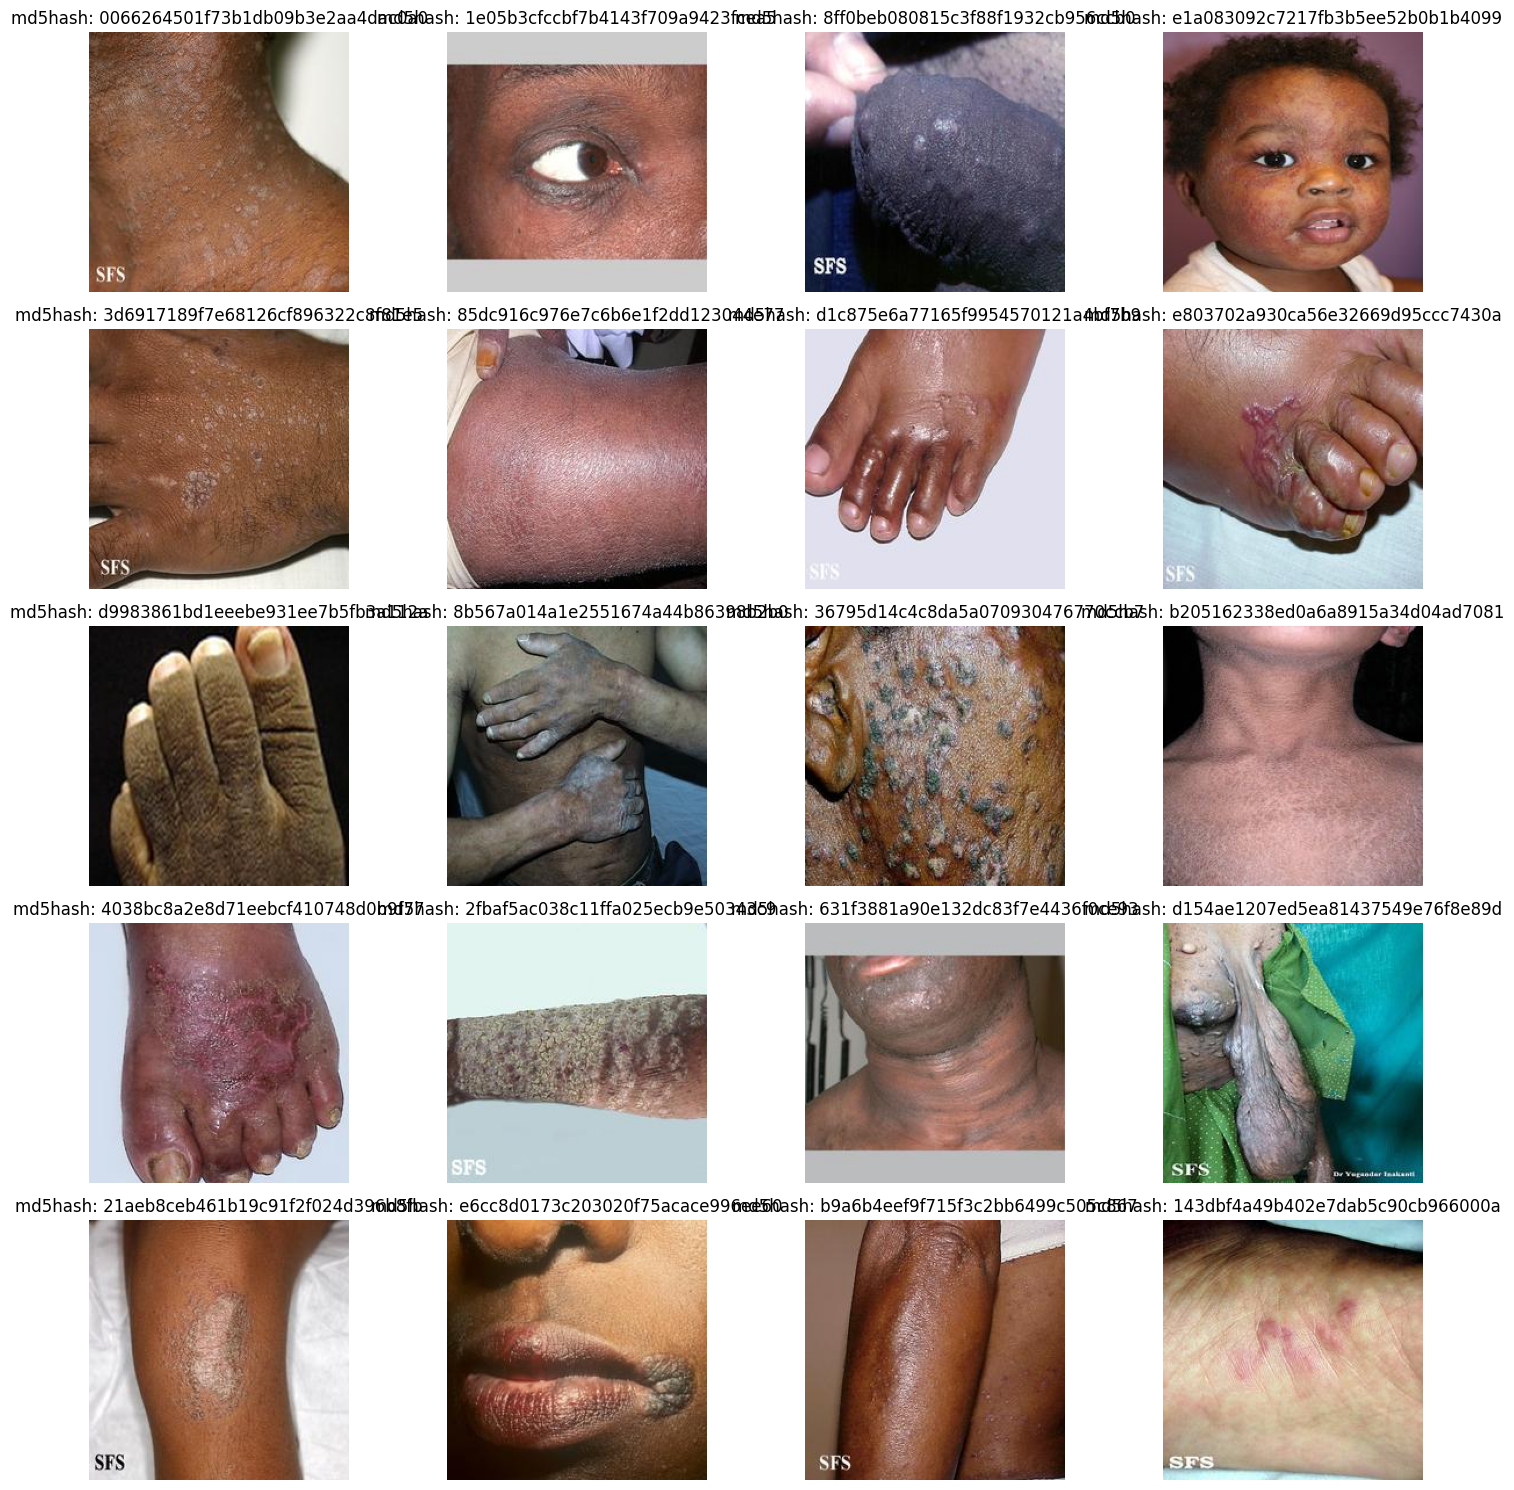

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Assuming df_img is your DataFrame
# Filter for fitzpatrick_scale 1, malignant, and train set
filtered_df = df_img[(df_img['fitzpatrick_scale'] == 6) &
                     (df_img['three_partition_label'] == 'non-neoplastic') &
                     (df_img['set'] == 'train')]

# Get the first/last 20 images from the filtered set
filtered_df = filtered_df.head(20)

# Plot the images
plt.figure(figsize=(15, 15))

# Loop through the filtered DataFrame and plot images
for idx, row in enumerate(filtered_df.iterrows()):  # `enumerate` ensures the correct index
    img_path = row[1]['resized_image_path']
    img = Image.open(img_path)

    plt.subplot(5, 4, idx+1)
    plt.imshow(img)
    plt.title(f"md5hash: {row[1]['md5hash']}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [82]:
# Collect the md5hash values into a list
md5hash_list = filtered_df['md5hash'].tolist()

# Print the list (or save it to a file if you want)
md5hash_list


['0066264501f73b1db09b3e2aa4dac0a0',
 '1e05b3cfccbf7b4143f709a9423fcea5',
 '8ff0beb080815c3f88f1932cb956ccb0',
 'e1a083092c7217fb3b5ee52b0b1b4099',
 '3d6917189f7e68126cf896322c8f81e5',
 '85dc916c976e7c6b6e1f2dd123044e77',
 'd1c875e6a77165f9954570121a4bf7b9',
 'e803702a930ca56e32669d95ccc7430a',
 'd9983861bd1eeebe931ee7b5fb3a112a',
 '8b567a014a1e2551674a44b86398b2b0',
 '36795d14c4c8da5a070930476770ccb7',
 'b205162338ed0a6a8915a34d04ad7081',
 '4038bc8a2e8d71eebcf410748d0b9f77',
 '2fbaf5ac038c11ffa025ecb9e50343c9',
 '631f3881a90e132dc83f7e4436f0ce93',
 'd154ae1207ed5ea81437549e76f8e89d',
 '21aeb8ceb461b19c91f2f024d396b8fb',
 'e6cc8d0173c203020f75acace996ee60',
 'b9a6b4eef9f715f3c2bb6499c505c867',
 '143dbf4a49b402e7dab5c90cb966000a']

In [ ]:
print("Keras (within TensorFlow) version:", tf.keras.__version__)


Keras (within TensorFlow) version: 3.4.1


In [ ]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.17.0
